In [22]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.append(os.path.abspath("../src/"))
import numpy as np
import scipy.stats
import h5py
from collections import OrderedDict
import modisco
import plot.viz_sequence as viz_sequence
import matplotlib.pyplot as plt
import tqdm
tqdm.tqdm_notebook(range(0))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/users/amtseng/miniconda3/envs/tfmodisco-mini/lib/python3.7/site-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


|<bar/>| 0/0 [00:00<?, ?it/s]

In [2]:
condition_name = "K562"
model_type = "binary"
missed_seqlets_path = "/users/amtseng/att_priors/results/missed_seqlets/%s_%s_missed_seqlets.h5" % (condition_name, model_type)

In [3]:
# Import the data
with h5py.File(missed_seqlets_path, "r") as f:
    input_seqs = f["input_seqs"][:]
    prior_hyp_scores = f["prior_hyp_scores"][:]
    noprior_hyp_scores = f["noprior_hyp_scores"][:]
    prior_ranked_bases = f["prior_ranked_bases"][:]
    noprior_ranked_bases = f["noprior_ranked_bases"][:]
    prior_missed_inds = f["prior_missed_inds"][:]
    noprior_missed_inds = f["noprior_missed_inds"][:]

In [15]:
# Collect the set of seqlets that don't overlap
def extract_unique_seqlets(hyp_scores, one_hot_seqs, ranked_bases, missed_inds, top_k=None, window_size=50):
    """
    From the top `top_k` ranked bases, centers a window of `window_size` (or as
    centered as possible if the base is close to the edge), and collates all the
    windows that don't overlap, favoring high-ranked windows. Returns the seqlets
    of the hypothetical scores and the one-hot encoded sequences. Also returns an
    N x 3 array of indices for each seqlet (sequence index, start index, end index).
    """
    missed_ranked_bases = ranked_bases[missed_inds[:top_k]]
    unique_missed_ranked_bases = []
    for _ in tqdm.notebook.trange(len(missed_ranked_bases)):
        if not missed_ranked_bases.size:
            break
        seq_index, base_index = missed_ranked_bases[0]
        unique_missed_ranked_bases.append(missed_ranked_bases[0])
        missed_ranked_bases = missed_ranked_bases[
            (missed_ranked_bases[:, 0] != seq_index) |
            (np.abs(missed_ranked_bases[:, 1] - base_index) > (window_size / 2))
        ]
    
    unique_missed_ranked_bases = np.stack(unique_missed_ranked_bases)
    
    seqlet_hyp_scores = np.empty((len(unique_missed_ranked_bases), window_size, 4))
    seqlet_input_seqs = np.empty((len(unique_missed_ranked_bases), window_size, 4))
    sequence_inds = np.empty((len(unique_missed_ranked_bases), 3), dtype=int)
    
    seq_length = hyp_scores.shape[1]
    seq_inds = unique_missed_ranked_bases[:, 0]
    starts = np.clip(unique_missed_ranked_bases[:, 1] - (window_size // 2), 0, seq_length - window_size)
    ends = starts + window_size
    
    for i in tqdm.notebook.trange(len(unique_missed_ranked_bases)):
        seq_index, start, end = seq_inds[i], starts[i], ends[i]
        sequence_inds[i] = np.array([seq_index, start, end])
        seqlet_hyp_scores[i] = hyp_scores[seq_index][start:end]
        seqlet_input_seqs[i] = one_hot_seqs[seq_index][start:end]
    
    return seqlet_hyp_scores, seqlet_input_seqs, sequence_inds

In [16]:
prior_seqlet_hyp_scores, prior_seqlet_input_seqs, prior_seqlet_inds = extract_unique_seqlets(
    prior_hyp_scores, input_seqs, prior_ranked_bases, prior_missed_inds, top_k=200000
)
noprior_seqlet_hyp_scores, noprior_seqlet_input_seqs, noprior_seqlet_inds = extract_unique_seqlets(
    noprior_hyp_scores, input_seqs, noprior_ranked_bases, noprior_missed_inds, top_k=200000
)

In [6]:
# Run TF-MoDISco
def run_tfmodisco(hyp_scores, one_hot_seqs, results_path, seqlet_size=25, window_size=50):
    task_to_hyp_scores, task_to_act_scores = OrderedDict(), OrderedDict()
    task_to_hyp_scores["task0"] = hyp_scores
    task_to_act_scores["task0"] = hyp_scores * one_hot_seqs
    
    track_set = modisco.tfmodisco_workflow.workflow.prep_track_set(
        ["task0"], task_to_act_scores, task_to_hyp_scores, one_hot_seqs
    )
    
    seqlets_to_patterns_factory = \
        modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
            trim_to_window_size=20,
            initial_flank_to_add=5,
            final_flank_to_add=0,
            kmer_len=8,
            num_gaps=3,
            num_mismatches=2,
            final_min_cluster_size=60
    )
    
    seqlets_to_patterns = seqlets_to_patterns_factory(
        track_set, "sequence", ["task0_contrib_scores"], ["task0_hypothetical_contribs"], [1]
    )
    
    seqlet_start = (window_size - seqlet_size) // 2
    seqlet_end = seqlet_start + seqlet_size
    seqlets = track_set.create_seqlets([
        modisco.core.SeqletCoordinates(i, seqlet_start, seqlet_end, False)
        for i in range(len(hyp_scores))
    ])
    
    results = seqlets_to_patterns(seqlets)
    with h5py.File(results_path, "w") as f:
        results.save_hdf5(f)
    return results

In [7]:
# Import TF-MoDISco results
def import_tfmodisco_results(hyp_scores, one_hot_seqs, results_path):
    task_to_hyp_scores, task_to_act_scores = OrderedDict(), OrderedDict()
    task_to_hyp_scores["task0"] = hyp_scores
    task_to_act_scores["task0"] = hyp_scores * one_hot_seqs
    
    track_set = modisco.tfmodisco_workflow.workflow.prep_track_set(
        ["task0"], task_to_act_scores, task_to_hyp_scores, one_hot_seqs
    )
    
    with h5py.File(results_path, "r") as f:
        results = modisco.tfmodisco_workflow.seqlets_to_patterns.SeqletsToPatternsResults.from_hdf5(
            f, track_set
        )
    return results

In [8]:
background_freqs = np.array([0.27, 0.23, 0.23, 0.27])
def info_content(track, pseudocount=0.001):
    """
    Given an L x 4 track, computes information content for each base and
    returns it as an L-array.
    """
    num_bases = track.shape[1]
    # Normalize track to probabilities along base axis
    track_norm = (track + pseudocount) / (np.sum(track, axis=1, keepdims=True) + (num_bases * pseudocount))
    ic = track_norm * np.log2(track_norm / np.expand_dims(background_freqs, axis=0))
    return np.sum(ic, axis=1)

In [9]:
def get_pfms_and_cwms(tfm_results, one_hot_seqs, hyp_scores, display=True):
    pfms, cwms, num_seqlets = [], [], []
    num_patterns = len(tfm_results.patterns)
    for i, pattern in enumerate(tfm_results.patterns):
        seqlets = pattern.seqlets_and_alnmts.get_seqlets()
        pfm = 0
        cwm = 0
        for seqlet in seqlets:
            coor = seqlet.coor
            seq_index, start_index, end_index = coor.example_idx, coor.start, coor.end
            
            seqlet_seq = one_hot_seqs[seq_index][start_index:end_index]
            seqlet_imp = hyp_scores[seq_index][start_index:end_index]
            
            if coor.is_revcomp:
                seqlet_seq = np.flip(seqlet_seq, axis=(0, 1))
                seqlet_imp = np.flip(seqlet_imp, axis=(0, 1))
            pfm = pfm + seqlet_seq
            cwm = cwm + seqlet_imp
        pfms.append(pfm)
        cwms.append(cwm)
        num_seqlets.append(len(seqlets))
    if display:
        for i in np.flip(np.argsort(num_seqlets)):
            print("Motif %d / %d (%d seqlets)" % (i + 1, len(num_seqlets), num_seqlets[i]))
            pfm, cwm = pfms[i], cwms[i]
            ic = info_content(pfm)
            pwm = np.expand_dims(ic, axis=1) * pfm
            viz_sequence.plot_weights(pwm)
            viz_sequence.plot_weights(cwm)
    return pfms, cwms, num_seqlets

In [40]:
def plot_relative_seqlet_importances(
    tfm_results, seqlet_inds, prior_hyp_scores, noprior_hyp_scores, one_hot_seqs
):
    num_patterns = len(tfm_results.patterns)
    for i, pattern in enumerate(tfm_results.patterns):
        seqlets = pattern.seqlets_and_alnmts.get_seqlets()
        prior_scores, noprior_scores = [], []
        for seqlet in seqlets:
            coor = seqlet.coor
            seqlet_index, seqlet_start, seqlet_end = coor.example_idx, coor.start, coor.end
            sequence_index, sequence_start, sequence_end = seqlet_inds[seqlet_index]
            
            start = seqlet_start + sequence_start
            end = start + (seqlet_end - seqlet_start)
            
            seq = one_hot_seqs[sequence_index][start:end]
            prior_imp = prior_hyp_scores[sequence_index][start:end]
            noprior_imp = noprior_hyp_scores[sequence_index][start:end]
            
            # Taking reverse complement technically doesn't matter:
            if coor.is_revcomp:
                seq = np.flip(seq, axis=(0, 1))
                prior_imp = np.flip(prior_imp, axis=(0, 1))
                noprior_imp = np.flip(noprior_imp, axis=(0, 1))
            
            # Compute total importance of the seqlet, normalized by maximum importance in the full sequence
            prior_score = np.max(np.abs(prior_imp * seq)) / np.max(np.abs(one_hot_seqs[sequence_index] * prior_hyp_scores[sequence_index]))
            noprior_score = np.max(np.abs(noprior_imp * seq)) / np.max(np.abs(one_hot_seqs[sequence_index] * noprior_hyp_scores[sequence_index]))
            prior_scores.append(prior_score)
            noprior_scores.append(noprior_score)
            
        # Plot the scores
#         bin_num = 30
#         all_vals = np.concatenate([noprior_scores, prior_scores])
#         bins = np.linspace(np.min(all_vals), np.max(all_vals), bin_num)
#         fig, ax = plt.subplots(figsize=(16, 8))
#         ax.hist(noprior_scores, bins=bins, color="coral", label="No prior", alpha=0.7)
#         ax.hist(prior_scores, bins=bins, color="slateblue", label="With Fourier prior", alpha=0.7)
#         plt.legend()
#         title = "Relative importance of missed motifs outside of footprints"
#         title += "\n%s %s models" % (condition_name, model_type)
#         plt.title(title)
#         plt.xlabel("Relative importance")
#         plt.show()

        print("Average score without priors: %f" % np.nanmean(noprior_scores))
        print("Average score with priors: %f" % np.nanmean(prior_scores))
        print("Standard error without priors: %f" % scipy.stats.sem(noprior_scores))
        print("Standard error with priors: %f" % scipy.stats.sem(prior_scores))
        w, p = scipy.stats.wilcoxon(noprior_scores, prior_scores, alternative="less")
        print("One-sided Wilcoxon test: W = %f, p = %f" % (w, p))

In [30]:
prior_results_path = "/users/amtseng/att_priors/results/missed_seqlets/%s_%s_prior_tfm_results.h5" % (condition_name, model_type)
# prior_tfm_results = run_tfmodisco(
#     prior_seqlet_hyp_scores, prior_seqlet_input_seqs, prior_results_path
# )
prior_tfm_results = import_tfmodisco_results(
    prior_seqlet_hyp_scores, prior_seqlet_input_seqs, prior_results_path
)

In [41]:
plot_relative_seqlet_importances(
    prior_tfm_results, prior_seqlet_inds, prior_hyp_scores, noprior_hyp_scores, input_seqs
)

Average score without priors: 0.446148
Average score with priors: 0.482174
Standard error without priors: 0.013815
Standard error with priors: 0.014182
One-sided Wilcoxon test: W = 58230.000000, p = 0.000293
Average score without priors: 0.179845
Average score with priors: 0.321823
Standard error without priors: 0.008686
Standard error with priors: 0.013690
One-sided Wilcoxon test: W = 20164.000000, p = 0.000000
Average score without priors: 0.263295
Average score with priors: 0.233261
Standard error without priors: 0.011547
Standard error with priors: 0.010461
One-sided Wilcoxon test: W = 56815.000000, p = 0.999920
Average score without priors: 0.478665
Average score with priors: 0.455179
Standard error without priors: 0.019389
Standard error with priors: 0.020023
One-sided Wilcoxon test: W = 22921.000000, p = 0.988738


Motif 1 / 4 (593 seqlets)


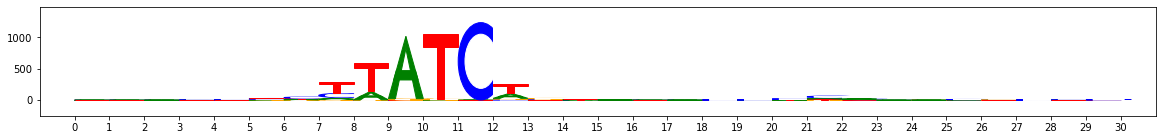

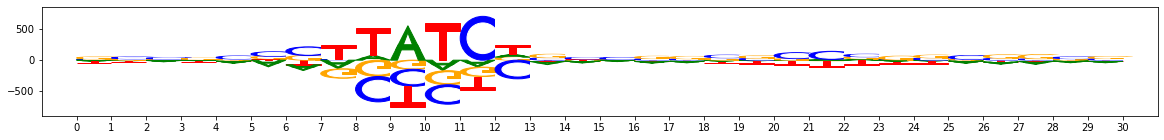

Motif 3 / 4 (437 seqlets)


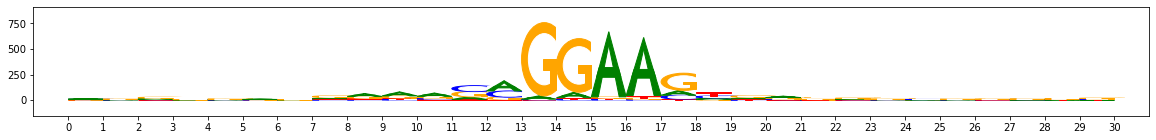

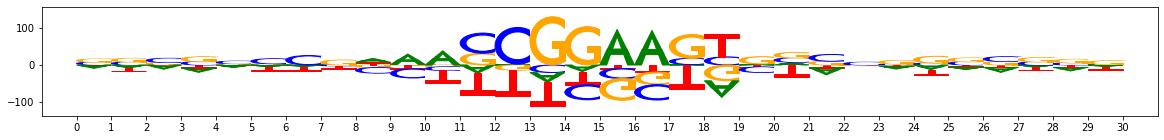

Motif 2 / 4 (435 seqlets)


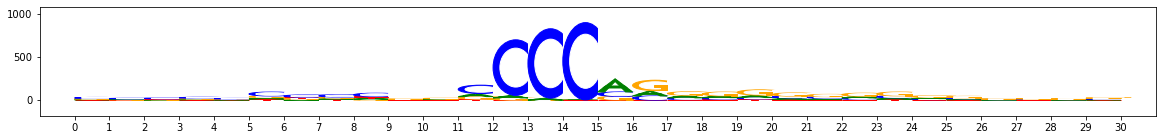

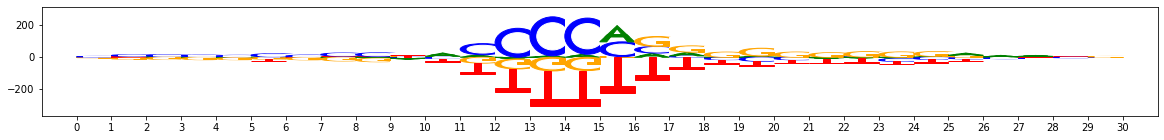

Motif 4 / 4 (318 seqlets)


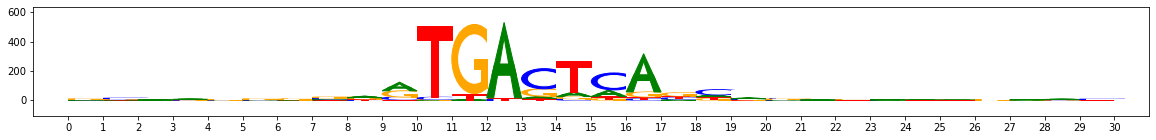

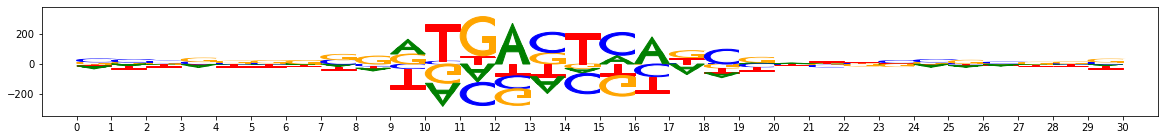

In [11]:
prior_pfms, prior_cwms, prior_num_seqlets = get_pfms_and_cwms(
    prior_tfm_results, prior_seqlet_input_seqs, prior_seqlet_hyp_scores
)

In [12]:
noprior_results_path = "/users/amtseng/att_priors/results/missed_seqlets/%s_%s_noprior_tfm_results.h5" % (condition_name, model_type)
# noprior_tfm_results = run_tfmodisco(
#     noprior_seqlet_hyp_scores, noprior_seqlet_input_seqs, noprior_results_path
# )
noprior_tfm_results = import_tfmodisco_results(
    noprior_seqlet_hyp_scores, noprior_seqlet_input_seqs, noprior_results_path
)

Motif 2 / 5 (590 seqlets)


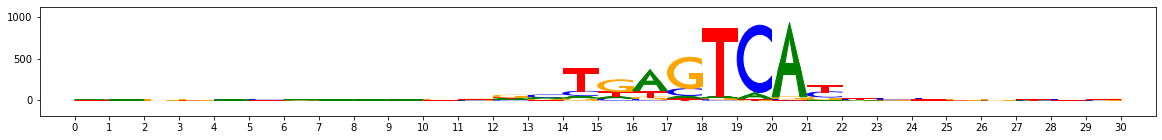

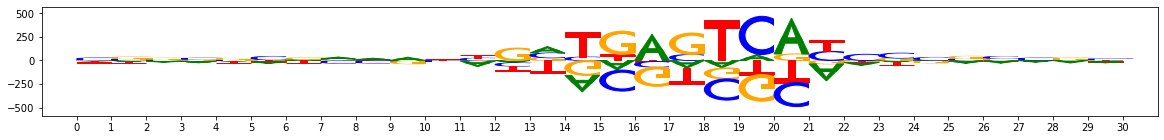

Motif 1 / 5 (445 seqlets)


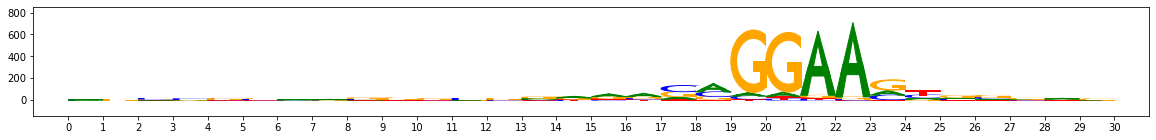

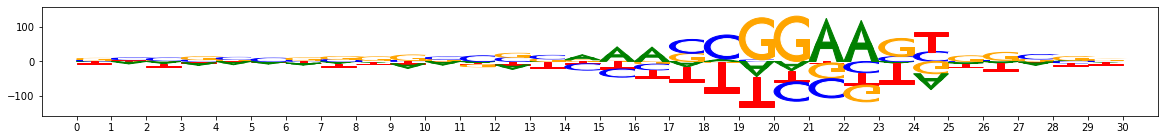

Motif 3 / 5 (171 seqlets)


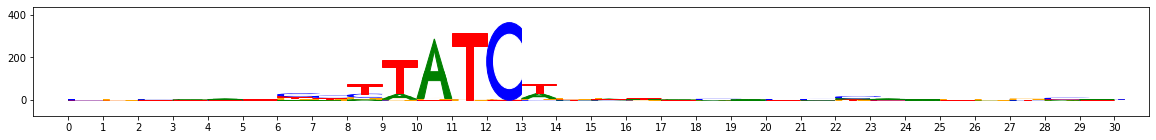

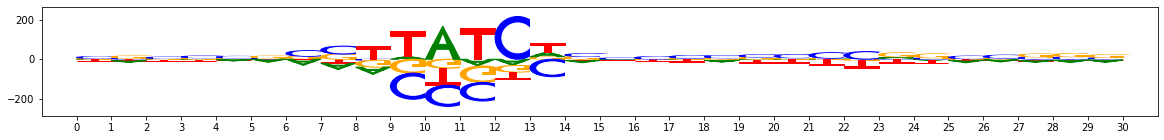

Motif 4 / 5 (85 seqlets)


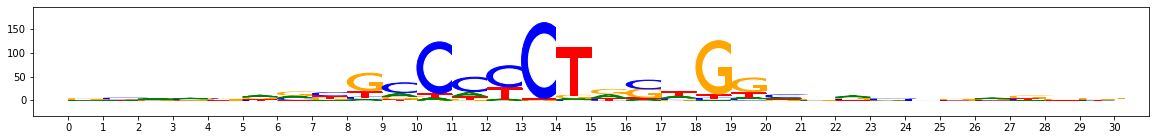

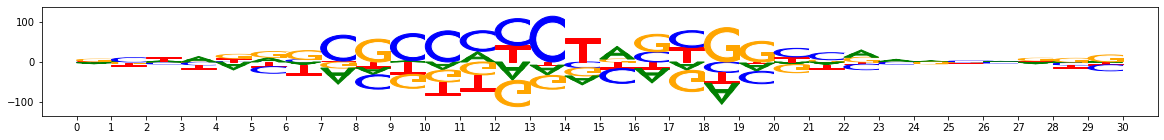

Motif 5 / 5 (72 seqlets)


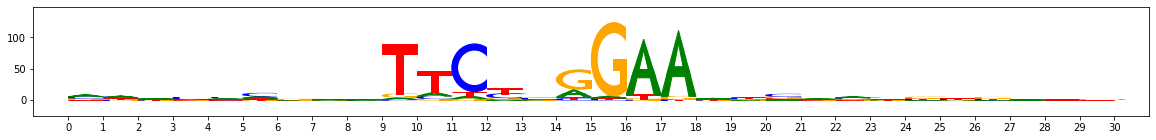

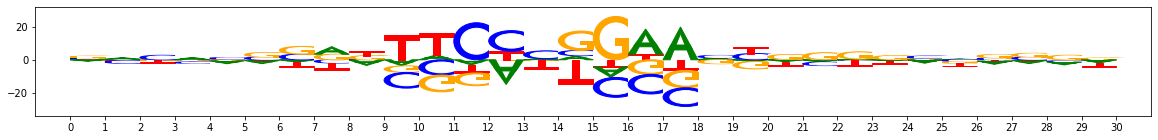

In [13]:
noprior_pfms, noprior_cwms, noprior_num_seqlets = get_pfms_and_cwms(
    noprior_tfm_results, noprior_seqlet_input_seqs, noprior_seqlet_hyp_scores
)